## Variational quantum state discriminator

Authored by **Vladyslav Los** (*vladyslav.los@rwth-aachen.de*, GitHub: *@vlalos*)


In this notebook we implement a quantum neural network and train it to discriminate between two sets of 2-qubit quantum states - Quantum State Discriminator (QSD). 

The implementation is based on the work done by <a href="https://link.springer.com/10.1007/s42484-020-00025-7" target="_blank">Chen et al. (2021)</a> and <a href="https://link.aps.org/doi/10.1103/PhysRevResearch.3.013063" target="_blank">Patterson et al. (2021)</a>.

In [1]:
# imports
from typing import List
from tqdm import tqdm #can be used for a progress bar in learning loop

import pennylane as qml
from pennylane import numpy as np

import matplotlib.pyplot as plt 

import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

%matplotlib inline

We use a set of pure states $ \psi_1(a) $, parametrized by a real number $ a \in \left[ 0, 1 \right]$, distributed accordingly to probability distribution $P(a)$: 

$ \psi_1(a) = \left( \sqrt(1 - a^2), 0, a, 0\right)$, 

and a set of mixed states consisting of, up to a sign, equal pure states $ \psi_{2/3}(b) $ , parametrized by a real number $ b \in \left[ 0, 1 \right]$, distributed accordingly to probability distribution $P(b)$:

$ \psi_{2/3}(b) = \left(0, \pm\sqrt(1 - b^2), b, 0\right)$.

In [56]:
#defining the device
dev = qml.device("default.qubit", wires=4)

def U(W: np.ndarray, wires: List[int]) -> None:
    """Pre-measurement entangling layer and arbitrary single-qubit rotations on ancilla qubits."""
    qml.Barrier(wires=[0, 1, 2, 3])
    for pair in [[3, 0], [3, 1], [2, 0], [2, 1]]:
        qml.CNOT(wires=[wires[i] for i in pair])
    qml.Barrier(wires=[0, 1, 2, 3])
    for i in range(2):
        qml.RX(W[0, i], wires=wires[i])
        qml.RZ(W[1, i], wires=wires[i])
        qml.RX(W[2, i], wires=wires[i]) 
    
def V(W: np.ndarray, wires: List[int]) -> None:
    """Layer predicated on the measurement outcome of the first ancilla qubit."""
    qml.CNOT(wires=[wires[i] for i in [2, 0]])
    qml.CNOT(wires=[wires[i] for i in [1, 0]])
    qml.RX(W[0, 0], wires=wires[0])
    qml.RZ(W[1, 0], wires=wires[0])
    qml.RX(W[2, 0], wires=wires[0])

@qml.qnode(dev, diff_method="parameter-shift")
def circuit(weights: np.ndarray, input: List[complex]) -> List[float]:
    """Quantum circuit."""
    # qml.BasisState(np.array([0,0]), wires=[0, 1])
    qml.QubitStateVector(np.array(input), wires=[2, 3])

    U(weights[0], wires = [0, 1, 2, 3])

    qml.ctrl(V, control=0, control_values=1)(weights[1], wires = [1, 2, 3])
    qml.Barrier(wires=[1, 2, 3])
    qml.ctrl(V, control=0, control_values=0)(weights[2], wires = [1, 2, 3])

    return qml.probs(wires = [0, 1])

The circuit ansatz we use in this project is as follows:

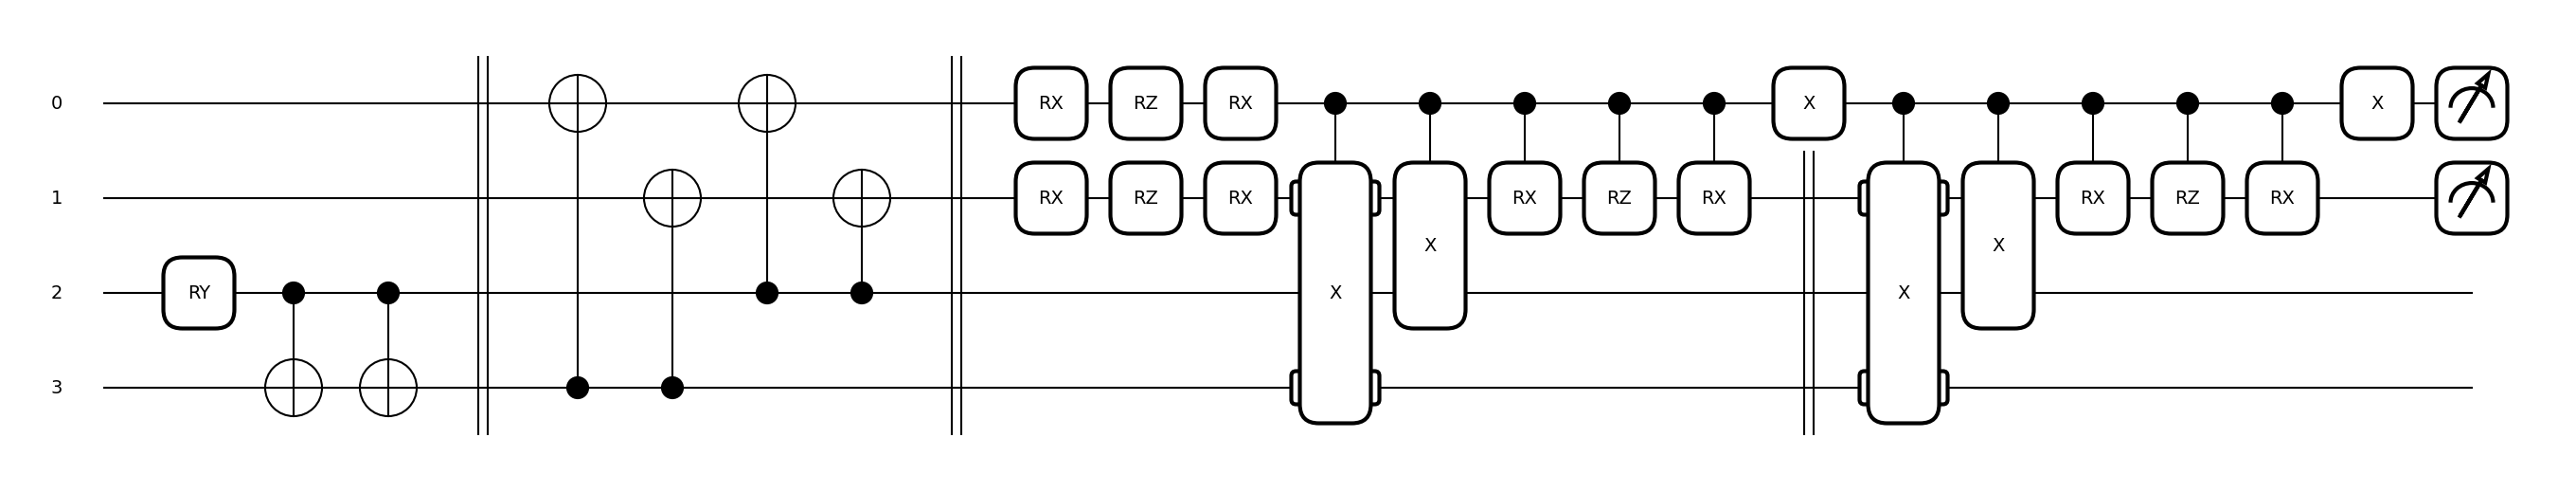

In [57]:
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(circuit)(np.random.random((3, 3, 3)), [np.sqrt(0.5) + 0.j, 0. + 0.j, np.sqrt(0.5) + 0.j, 0. + 0.j]) 
fig.show()

We define the cost function as follows: 

$C = \sum_i \frac{1}{\left|{S_i}\right|} \sum_{a_i/b_i \in S_i} [1 - P_{suc}(\psi_i (a_i/b_i))] + \alpha_{err} \sum_i \frac{1}{\left|{S_i}\right|} \sum_{a_i/b_i \in S_i} P_{err}(\psi_i (a_i/b_i)) + \alpha_{inc} \sum_i \frac{1}{\left|{S_i}\right|} \sum_{a_i/b_i \in S_i} P_{inc}(\psi_i (a_i/b_i))$

Cost function decreases as the success probability $P_{suc}$ increases. The penalties for errors and inconclusive outputs ($P_{err}$ and $P_{inc}$) are regulated by the set parameters $\alpha_{err}$ and $\alpha_{inc}$. The $S_i$ with $i \in [1,2]$ means the sample batch of states $\psi_{1, 2/3}$  

In [4]:
def cost(weights: np.ndarray, batch_a: np.ndarray, batch_b: np.ndarray, a_err: int, a_inc: int) -> float:
    """Cost function for the QSD."""
    
    prob_a = np.array([circuit(weights, input) for input in batch_a])
    prob_b = np.array([circuit(weights, input) for input in batch_b])

    cost_a = 1 / len(batch_a) * (np.sum(np.ones(len(batch_a)) - prob_a[:, 0] - prob_a[:, 2]) + a_err * np.sum(prob_a[:, 1]) + a_inc * np.sum(prob_a[:, 3]))
    cost_b = 1 / len(batch_b) * (np.sum(np.ones(len(batch_b)) - prob_b[:, 1]) + a_err * np.sum(prob_b[:, 0] + prob_b[:, 2]) + a_inc * np.sum(prob_b[:, 3]))
    
    return cost_a + cost_b

For learning, we generate two batches of training data: $S_1$ with states $\psi_1(a_i)$, where $a_i \in [0,1]$ are distributed according to the normal distribution $P(a)$ with $\mu_a = 0.5, \sigma_a = 0.15$; and $S_2$ with states $\psi_{2/3}(b = \frac{1}{\sqrt{2}})$, where we randomly select between $\psi_2$ and $\psi_3$ emulating a mixed state

In [35]:
def get_batch(batch_size: int, a_int: List[float] = [0., 1.]) -> np.ndarray:
    """Generate a batch of inputs based on P(a)."""
    
    P_a = np.random.normal(0.5, 0.15, batch_size)
    P_a = np.clip(P_a, a_int[0], a_int[1])

    pm = np.random.choice([-1, 1], batch_size, p=[0.5, 0.5])

    batch_a = []
    batch_b = []
    for a in P_a:
        input = np.array([np.sqrt(1 - a**2) + 0.0j, 0.0 + 0.0j, a + 0.0j, 0.0 + 0.0j])
        batch_a.append(input)

    for sign in pm:
        input = np.array([0.0 + 0.0j, sign*np.sqrt(0.5) + 0.0j, np.sqrt(0.5) + 0.0j, 0.0 + 0.0j])
        batch_b.append(input)

    return np.array(batch_a), np.array(batch_b)

In [7]:
batch_size = 20
num_batches = 500

#cost function parameters

alphas = [[20, 2], [5, 20], [20,20]]

#optimizer parameters
etas = [0.1, 0.01, 0.001]
beta1 = 0.9
beta2 = 0.999
eps = 1e-08


init_weights = np.random.random((3, 3, 3), requires_grad=True)





Now, we train our QNN with different learning rates $\eta$ and different sets of penalties for error $\alpha_{err}$ and inconclusive $\alpha_{inc}$ outcome, where we discriminate between unambiguous discrimination ($\alpha_{err} > \alpha_{inc}$), balanced strategy ($\alpha_{err} = \alpha_{inc}$) and minimimal error discrimination ($\alpha_{err} < \alpha_{inc}$).

In [15]:
weights = init_weights

class Run:
    def __init__(self, eta: float, a_err: int, a_inc:int):
        self.eta = eta
        self.a_err = a_err
        self.a_inc = a_inc
        self.cost = []
        self.prob_a = []
        self.weights: np.ndarray

results: List[Run] = []


for eta in etas:
    print("eta = {}".format(eta))
    opt = qml.AdamOptimizer(eta, beta1, beta2, eps)

    for a_err, a_inc in alphas:
        print("a_err = {} | a_inc = {}".format(a_err, a_inc))
        run = Run(eta, a_err, a_inc)
        
        for i in range(num_batches):

            batch_a, batch_b = get_batch(batch_size)
            
            weights, _, _, _, _ = opt.step(cost, weights, batch_a, batch_b, a_err, a_inc)

            prob_a = [(circuit(weights, input)[0] +  circuit(weights, input)[2]) for input in batch_a] 
            prob_a = sum(prob_a)/len(prob_a)

            run.cost.append(cost(weights, batch_a, batch_b, a_err, a_inc))
            run.prob_a.append(prob_a)

            if i % 25 == 0:
                print("Iter: {} | Cost = {} | P_a = {}".format(i + 1, run.cost[i], run.prob_a[i]))

        run.weights = weights
        weights = init_weights
        results.append(run)
            
    


eta = 0.1
a_err = 20 | a_inc = 2
Iter: 1 | Cost = 12.17265113273757 | P_a = 0.1541279301665432
Iter: 26 | Cost = 5.8078323991992065 | P_a = 0.6915295890389771
Iter: 51 | Cost = 4.107708251909093 | P_a = 0.7187776270231965
Iter: 76 | Cost = 3.936190549118071 | P_a = 0.7002424935563228
Iter: 101 | Cost = 3.7262593428501685 | P_a = 0.7580431450699321
Iter: 126 | Cost = 3.689130328884129 | P_a = 0.7703035962600701
Iter: 151 | Cost = 3.7778994269527066 | P_a = 0.7407027987977706
Iter: 176 | Cost = 3.993968130565147 | P_a = 0.6686774142153953
Iter: 201 | Cost = 4.020680754875663 | P_a = 0.6597730838169602
Iter: 226 | Cost = 4.008572442236965 | P_a = 0.6638091863979043
Iter: 251 | Cost = 3.966771998972407 | P_a = 0.6777426671139464
Iter: 276 | Cost = 3.825877866749083 | P_a = 0.724707377758324
Iter: 301 | Cost = 3.896950062608398 | P_a = 0.7010166457982177
Iter: 326 | Cost = 3.6532455853405486 | P_a = 0.7822514715531825
Iter: 351 | Cost = 3.8756510162553806 | P_a = 0.7081163279148788
Iter: 37

First, we take a look at the convergence of the optimization for different learning rates. As expected, convergence rate increases with the learning rate 

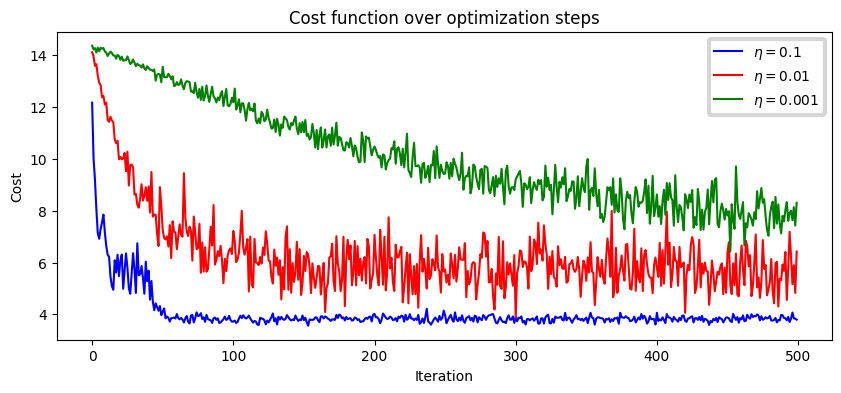

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4)) 

ax.plot(results[0].cost, label="$\\eta = {}$".format(results[0].eta), color="blue")
ax.plot(results[3].cost, label="$\\eta = {}$".format(results[3].eta), color="red")
ax.plot(results[6].cost, label="$\\eta = {}$".format(results[6].eta), color="green")

ax.set_xlabel("Iteration")
ax.set_ylabel("Cost")

ax.set_title("Cost function over optimization steps")
ax.legend()

fig.show()

Now we do some testing on the optimized weights set. For that, much like in training phase, we generate to batches of 250 states, according to the corresponding probability distributions

In [69]:
def test(weights: np.ndarray, test_batch: np.ndarray) -> None:
    """Test the trained circuit."""
    prob_a = []
    prob_b = []
    prob_inc = []

    for input in test_batch:
        probs = circuit(weights, input)
        prob_a.append(probs[0] + probs[2])
        prob_b.append(probs[1])
        prob_inc.append(probs[3])
    
    prob_a = sum(prob_a)/len(prob_a)
    prob_b = sum(prob_b)/len(prob_b)
    prob_inc = sum(prob_inc)/len(prob_inc)
    
    print("P(a) = {}".format(prob_a), "P(b) = {}".format(prob_b), "P(inc) = {}".format(prob_inc))

    return prob_a, prob_b, prob_inc

In [72]:
test_batch_a, test_batch_b = get_batch(250)

print("eta = {}".format(results[2].eta))
print("a_err = {} | a_inc = {}".format(results[2].a_err, results[2].a_inc))
print("Test results for a:")
test(results[2].weights, test_batch_a)
print("Test results for b:")
test(results[2].weights, test_batch_b)


eta = 0.1
a_err = 20 | a_inc = 20
Test results for a:
P(a) = 0.7144066954954756 P(b) = 0.2855933045045243 P(inc) = 2.2178603539581276e-25
Test results for b:
P(a) = 3.738329269985941e-24 P(b) = 1.0000000000000002 P(inc) = 3.4928268614426727e-28


(tensor(3.73832927e-24, requires_grad=True),
 tensor(1., requires_grad=True),
 tensor(3.49282686e-28, requires_grad=True))

In case of balanced strategy, we have a probability of success for $a$ of $0.714$, the success rate for $b$ is pretty much $1.0$. Interestingly, most of the mismeasurement for $a$ is still concentrated on measuring $\psi_{2/3}$. Let us dive deeper into that. In the following we take a testing batch of $a \in [0.0, 1.0]$ and $a \in [0.9, 1.0]$ to see the performance on the margins. As the overlap between the states is dependent on $a$: $\left|\langle \psi_1|\psi_{2/3}\rangle\right| = ab$, we expect the results for higher values of $a$ to be a lot worse.

In [73]:
test_batch = {"a": [], "b": []}
test_batch_a, test_batch_b = get_batch(250, a_int=[0., 0.1])
test_batch["a"].append(test_batch_a)
test_batch["b"].append(test_batch_b)

test_batch_a, test_batch_b = get_batch(250, a_int=[0.9, 1.])
test_batch["a"].append(test_batch_a)
test_batch["b"].append(test_batch_b)

a_pa, a_pb, a_pinc = {"$ a \\in [0.,0.1]$": [], "$ a \\in [0.9,1.]$": []}, {"$ a \\in [0.,0.1]$": [], "$ a \\in [0.9,1.]$": []}, {"$ a \\in [0.,0.1]$": [], "$ a \\in [0.9,1.]$": []}
b_pa, b_pb, b_pinc = {"$ a \\in [0.,0.1]$": [], "$ a \\in [0.9,1.]$": []}, {"$ a \\in [0.,0.1]$": [], "$ a \\in [0.9,1.]$": []}, {"$ a \\in [0.,0.1]$": [], "$ a \\in [0.9,1.]$": []}

for i in range(0, 3):
    run = results[i]
    prob_a, prob_b, prob_inc = test(run.weights, test_batch["a"][0])
    a_pa["$ a \\in [0.,0.1]$"].append(prob_a)
    a_pb["$ a \\in [0.,0.1]$"].append(prob_b)
    a_pinc["$ a \\in [0.,0.1]$"].append(prob_inc)

    prob_a, prob_b, prob_inc = test(run.weights, test_batch["a"][1])
    a_pa["$ a \\in [0.9,1.]$"].append(prob_a)
    a_pb["$ a \\in [0.9,1.]$"].append(prob_b)
    a_pinc["$ a \\in [0.9,1.]$"].append(prob_inc)

    prob_a, prob_b, prob_inc = test(run.weights, test_batch["b"][0])
    b_pa["$ a \\in [0.,0.1]$"].append(prob_a)
    b_pb["$ a \\in [0.,0.1]$"].append(prob_b)
    b_pinc["$ a \\in [0.,0.1]$"].append(prob_inc)

    prob_a, prob_b, prob_inc = test(run.weights, test_batch["b"][1])
    b_pa["$ a \\in [0.9,1.]$"].append(prob_a)
    b_pb["$ a \\in [0.9,1.]$"].append(prob_b)
    b_pinc["$ a \\in [0.9,1.]$"].append(prob_inc)

P(a) = 0.9900000000000032 P(b) = 7.529756232108076e-24 P(inc) = 0.009999999999999962
P(a) = 0.18977357742359324 P(b) = 2.8181550692802373e-22 P(inc) = 0.8102264225764082
P(a) = 4.271597100973909e-24 P(b) = 3.468621848903651e-22 P(inc) = 1.0000000000000002
P(a) = 4.271593251271062e-24 P(b) = 3.468621848903651e-22 P(inc) = 1.0
P(a) = 0.9900000000000032 P(b) = 0.009999999999999962 P(inc) = 1.7337873529551884e-25
P(a) = 0.18977357742359324 P(b) = 0.8102264225764082 P(inc) = 1.5313735861786226e-25
P(a) = 4.7397979261057346e-24 P(b) = 1.0 P(inc) = 1.4832026335647002e-25
P(a) = 4.7397925031115586e-24 P(b) = 1.0 P(inc) = 1.4831958095898978e-25
P(a) = 0.9900000000000034 P(b) = 0.009999999999999962 P(inc) = 3.0719295020337966e-25
P(a) = 0.18977357742359324 P(b) = 0.8102264225764082 P(inc) = 5.916792306820159e-26
P(a) = 3.738311969186307e-24 P(b) = 1.0000000000000002 P(inc) = 3.4928162468785296e-28
P(a) = 3.7383177361195185e-24 P(b) = 1.0000000000000002 P(inc) = 3.492819785066575e-28


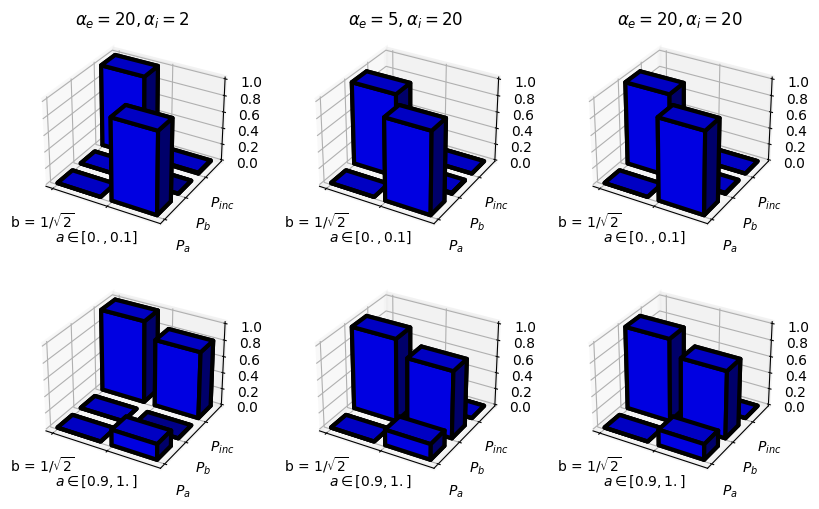

In [74]:
fig = plt.figure(constrained_layout=True, figsize=(10, 9))

for j, key in enumerate(a_pa.keys()):

    for i in range(0, 3):
        run = results[i]

        matrix = np.array([[b_pa[key][i], b_pb[key][i], b_pinc[key][i]], [a_pa[key][i], a_pb[key][i], a_pinc[key][i]]])

        ax = fig.add_subplot(3, 3, j * 3 + i +1, projection='3d')

        xpos = [range(matrix.shape[0])]
        ypos = [range(matrix.shape[1])]
        xpos, ypos = np.meshgrid(xpos, ypos)
        xpos = xpos.flatten('F')
        ypos = ypos.flatten('F')
        zpos = np.zeros_like(xpos)

        dx = 0.8 * np.ones_like(zpos)
        dy = 0.8 * dx.copy()
        dz = matrix.flatten()

        ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b', zsort='average')
        ax.set_xticks([0, 1])
        ax.set_xticklabels(["b = 1/$\\sqrt{2}$", key])
        ax.set_yticks([0, 1, 2])
        ax.set_yticklabels(["$P_a$", "$P_b$", "$P_{inc}$"])
        ax.set_zticks(np.linspace(0, 1, 6))

        if j == 0:
            ax.set_title("$\\alpha_e = {}, \\alpha_i = {}$".format(run.a_err, run.a_inc))


fig.tight_layout()
plt.show()

As expected, our QNN is effective in discrimination between the given states, if the overlap is small. In case of big overlap, the probability of the mismeasurement for $a$ is shifted from false $b$ in case of unambiguous discrimination to inconclusive result in case of minimal error discrimination. We see, that balanced strategy does not significantly differ from that of minimal error. Deeper look into penalty parameter tuning could show if there is more to that behaviour.

It is important to notice, that the probabilities we are getting for the $a$ batches are somewhat higher that those described by <a href="https://link.springer.com/10.1007/s42484-020-00025-7" target="_blank">Chen et al. (2021)</a>. Intuitive explanation for this would be, that the function <code> np.clip() </code> creates additional weight on the interval borders, disturbing the probability distribution. A deeper look into that might prove this hypothesis or reveal more sophisticated uncertainties of our model.

**Open questions**

- Increasing the dimensionality of the input states. Here a higher number of ancilla qubits is needed, and therefore a more complex circuit will be trained
- Tuning the optimizer hyperparameters and reward/penalty parameters of the cost function: in-depth analysis can return an optimal QSD. 